В данном ноутбуке будем визуально смотреть и проверять, как наша обученная модель справляется с сегментацией.

Необходимые импорты

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50

import torch

c:\Users\Кирилл\Documents\GitHub\CV_ITMO_2023\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Создание датасета, будем брать его целиком

In [2]:
root = Path('./data/output/for_torchgeo_way')
assert root.exists()

In [3]:
def scale(item: dict):
    item['image'] = (item['image']-torch.min(item['image']))/(torch.max(item['image'])-torch.min(item['image']))
    return item

In [4]:
#res - resolution, like the scale of the image, 10 means 10 m in pixel, as it is in Sentinel-2
ds_imgs = RasterDataset(root=(root/'img_f/train').as_posix(), crs='epsg:32637', res=10, transforms=scale) 
ds_msks = RasterDataset(root=(root/'mask_f/train').as_posix(), crs='epsg:32637', res=10)

ds_msks.is_image = False
ds_dset = ds_imgs & ds_msks

ds_sampler = RandomGeoSampler(ds_imgs, size=256, length=600, units=Units.PIXELS)
ds_dataloader = DataLoader(ds_dset, sampler=ds_sampler, batch_size=8, collate_fn=stack_samples)


Загрузка модели

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = deeplabv3_resnet50(weights=None, num_classes=2)
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=5, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

backbone.register_module('conv1', conv)
model.load_state_dict(torch.load('./test.pt'))
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Добавление индекса

In [6]:
tfms = torch.nn.Sequential(
    indices.AppendNDVI(index_nir=3, index_red=0),
)

Функция для отрисовки

In [7]:
def visualize_preds(model, ds_batch, batch_to_show, save_title = None):
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    # np.random.seed(seed)
    # if indices == None:
    #     indices = np.random.randint(low = 0, high = len(train_set),
    #                                 size = num_samples)
    # sns.set_style("white")
    num_samples = len(batch_to_show)
    X = batch_to_show.type(torch.float32)
    pred = model(X)['out']
    normalized_masks = pred.softmax(dim=1)
    class_to_idx = {'no_heracleum': 0, 'heracleum': 1}
    mask = normalized_masks[:, class_to_idx["heracleum"]].detach().numpy()
    width = 5
    w = width * 3
    h = width * num_samples

    fig, ax = plt.subplots(figsize = (w,h),
                           nrows = num_samples, ncols = 3)
    
    for i in range(num_samples):

        img = ds_batch['image'][i]
        arr = img[:3, :, :].permute(1, 2, 0).numpy()

        ax[i,0].imshow(arr)
        ax[i,0].set_title("True Image")
        ax[i,0].axis("off")
        
        ax[i,1].imshow(ds_batch['mask'][i].squeeze(), cmap='Greens')
        ax[i,1].set_title("Labels")
        ax[i,1].axis("off")
        
        ax[i,2].imshow(mask[i], cmap='Blues')
        ax[i,2].set_title("Predictions")
        ax[i,2].axis("off")

    fig.suptitle("Visual Check", fontsize = 20)
    plt.tight_layout()
    if save_title is not None:
        plt.savefig(save_title + ".png")
    plt.show()

Визуальная проверка обученной модели

In [16]:
ds_batch = next(iter(ds_dataloader))
batch_to_show = tfms(ds_batch['image'])

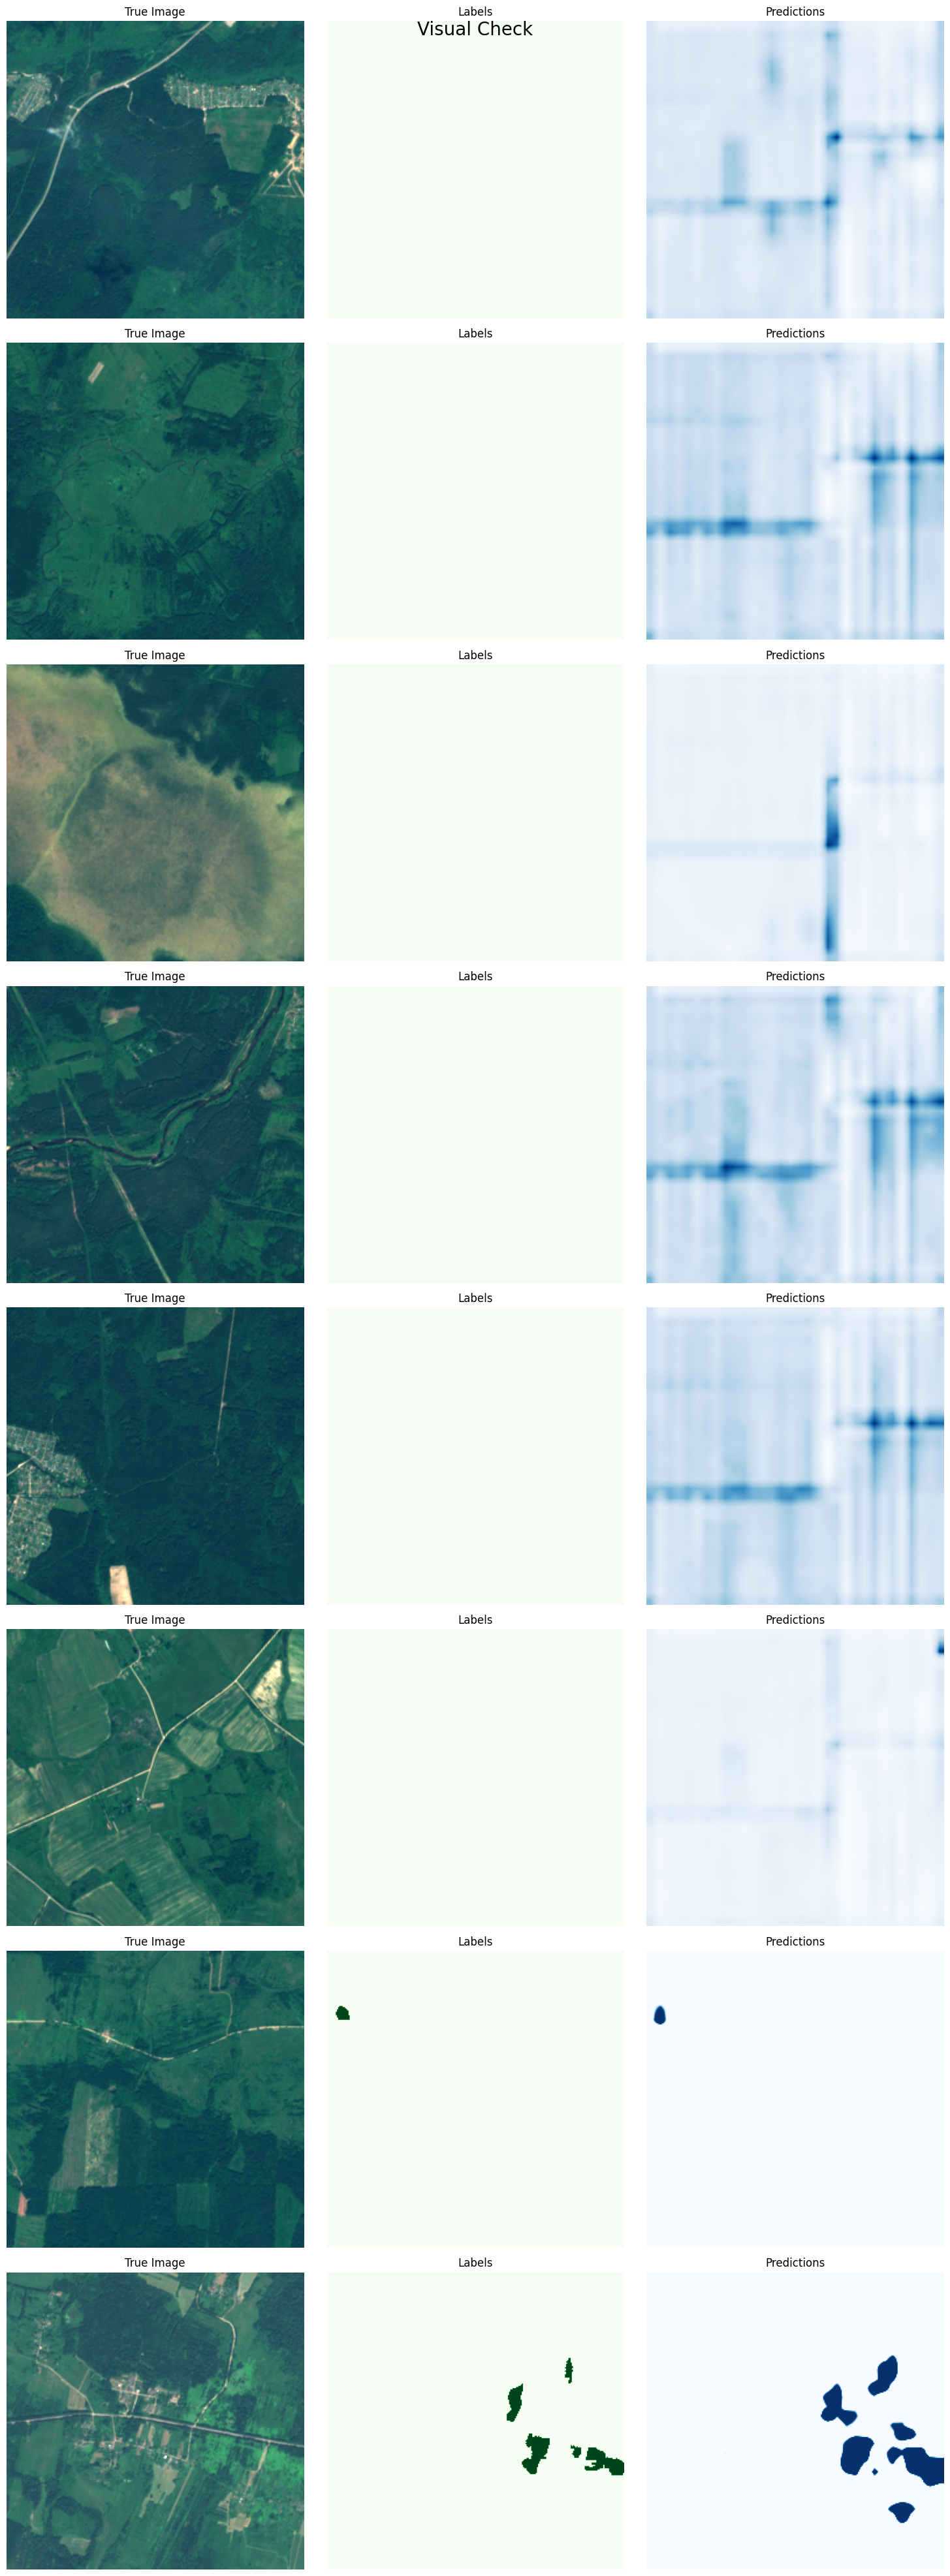

In [17]:
visualize_preds(model, ds_batch, batch_to_show)